# Scope
This documents describes the theory behind the library of functions developed for the SweSOC project.  
The library is a generic and modular SOC modeling framework, including a few models and climate scaling functions, together with a few implementation of Bayesian model comparison approaches. The frameworks is built for modularity and generalization, so that all functions can be combined easily with each other.  
The main purpose of this document is to provide documentation for each building block (with emphasis on the collection of scaling functions and SOC decomposition models).


# Main modeling blocks
The soil SOC evolution is generally simulated with a compartmental SOC model and some functions linearly scaling the decomposition kinetics, so very coarsely:
```mermaid
graph TD

    AirT((Temperature)) --> SoilTmodel[Soil temp model]
    SoilTmodel --> SoilT((Soil Temp))
    MoistWe((Weather data)) --> SoilWmodel[Soil weather model]
    SoilWmodel --> SoilW((Soil Moisture))

    SoilT --> SoilTscaling[Soil temperature modifier]
    SoilTscaling --> SoilTxi((Soil T scaling))
    SoilW --> SoilWscaling[Soil water modifier]
    SoilWscaling --> SoilWxi((Soil W scaling))
    Edaphic((Edaphic data)) --> SoilEMod[Soil edaphic model]
    SoilEMod --> SoilExi((Soil E scaling))


    SoilTxi --> SOC[SOC decomposition model]
    SoilWxi --> SOC
    SoilExi --> SOC

    SOC --> SOCsim[Simulated SOC over time]

```

Each of these operator blocks (the square blocks) can be represented by different functions, and will be written as a separate module. All modules operating the same function will be interchangeable.


# General SOC model structure
Any compartmental soil organic matter decomposition model can be written as:
$$
\frac{dC}{dt} = I - \xi \cdot A \cdot C
$$

Which in extended form becomes:

$$
\frac{d}{dt} \begin{bmatrix} C_1 \\  C_2 \\ \vdots \\ C_n \end{bmatrix} = \begin{bmatrix} I_1 \\ I_2 \\ \vdots \\ I_n \end{bmatrix} - \xi \cdot \begin{bmatrix}
k_{1} & h_{12} & \cdots & h_{1n} \\
h_{21} & k_{2} & \cdots & h_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
h_{n1} & h_{n2} & \cdots & k_{n}
\end{bmatrix} \begin{bmatrix} C_1 \\ C_2 \\ \vdots \\ C_n \end{bmatrix}
$$

the $\xi$ term is a scalar interacting linearly with all the kinetic terms $k$ and summarizes all the interactions with decomposition kinetics. These can be climatic (for all models) and edaphic (some models only).

$$
\xi = \xi_{temp} \cdot \xi_{moist} \cdot \xi_{clay} \cdot \xi_{...}
$$


In [1]:
# import important libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az 
from datetime import datetime, timedelta

# Climate and edaphic interactions
Climate and edaphic interactions are considered as scaling of the kinetics $k$

### Simulation of soil temperature



### Simulation of soil moisture

## Climate scaling functions
The functions collected in this library are from various models

### Temperature scaling functions

#### RothC

In [ ]:
def ft_RothC(TempC):
    
    '''
    
Effects of temperature on decomposition rates according to the functions
 included in the RothC model
 
 Calculates the effects of temperature on decomposition rates according to
the functions included in the RothC model.
 
 Temp A scalar or vector containing values of temperature for which
 the effects on decomposition rates are calculated.
 return A scalar or a vector containing the effects of temperature on
 decomposition rates (unitless).
  @note This function returns NA for Temp <= -18.3
  @references Jenkinson, D. S., S. P. S. Andrew, J. M. Lynch, M. J. Goss, and
   P. B. Tinker (1990), The Turnover of Organic Carbon and Nitrogen in Soil,
   Philosophical Transactions: Biological Sciences, 329(1255), 361-368.
    
    '''
    #Temp=TempC+273.16
    ft_rothC=47.9/(1+np.exp(106/(np.where(TempC<= -18.3, np.nan, TempC)+18.3)))
    return ft_rothC

: 

#### ICBMa: Arrhenius

In [ ]:
def arrhenius_factor(TempC, A=1000,Ea=75000, Re=8.3144621):
    '''
Effects of temperature on decomposition rates according the Arrhenius
equation
The function calculates the effects of temperature on decomposition rates according to the Arrhenius equation and returns 
A scalar or a vector containing the effects of temperature on decomposition rates (unitless).

TempC: A scalar or vector containing values of temperature (in degrees celcius) for which the effects on decomposition rates are calculated.
A: A scalar defining the pre-exponential factor.
Ea: A scalar defining the activation energy in units of J mol^-1.
Re A scalar defining the universal gas contents in units of J K^-1 mol^-1.

    '''
    Temp=TempC+273.16
    arr_factor=A*np.exp(-Ea/(Re*Temp))
    return arr_factor

: 

#### ICBMb: Andren_Katterer 2001

In [ ]:
def Andren_Katterer(TempC):
    '''
The dependence of decomposition rates on soil temperature was calculated following Andren and Katterer 2001 equation (27)
The function calculates the effects of temperature on decomposition rates according to the Arrhenius equation and returns 
A scalar or a vector containing the effects of temperature on decomposition rates (unitless).

TempC: A scalar or vector containing values of temperature (in degrees celcius) for which the effects on decomposition rates are calculated.
note This function returns NA for Temp <= -4

    
    '''
    Tempmax=23
    Tempmin=-4
    rateandren=((TempC-Tempmin)**2)/(Tempmax-Tempmin)**2
    rateandren=np.where(TempC<Tempmin, 0, rateandren)
    return rateandren

    # TempC=np.where(TempC<-4, 0, rateandren)
    # rateandren=((TempC--4)**2)/(23--4)**2

    return rateandren

: 

#### ICBMc: Ratkowski


In [ ]:
def ratkowski(TempC, 
                           C=0.00522739,
                           DHA=69.515,
                           n=388,
                           DH=5311,
                           DCp=81.36):
    Maxtemp=308.3 #temperature where proteins start to denaturate, taken from Ratkowski 2005, tab2, Tmes of S. thermophilus K120-6
    Temp=TempC+273.16
     
    # Ratkowski 2005 part
    r_ratkowski=(C*Temp*np.exp(-DHA/(8.314*Temp)))/(1+np.exp(-n*(DH-18.1*Temp+DCp*((Temp-373.6)-Temp*np.log(Temp/385.2)))/(8.314*Temp)))

    return   r_ratkowski

: 

### ICBMd: lloyd and taylor 1994

In [ ]:
# Taken from Lorenzo R code:
def lloyd_taylor(TempC):
    E0=308.56
    Tmin=227.13
    Temp=TempC+273.16
    Ea=53 # following lloyd and taylor 1996 paper
    lloyd_taylor_r= 0.1604316*np.exp((Ea*1000/(283.15*8.314))*(1-(283.15/Temp)))
    return lloyd_taylor_r


# following equation 11 as described in lloyd and taylor 1994 paper
def lloyd_taylor_11(TempC):
      E0=308.56
      Tmin=227.13
      Temp=TempC+273.16
      Q10= np.exp(10*E0/(Temp-Tmin)**2)
      R=Q10*np.exp(E0*((1/56.02)-(1/(Temp-Tmin))))
      return R

: 

### ICBMe: Lloyd and Taylor combined with Ratkowski

In [ ]:
def combined_ratkowski_lloyd_taylor(TempC,C=0.00522739,
                           DHA=69.515,
                           n=388,
                           DH=5311,
                           DCp=81.36):
    Maxtemp=308.3
    Temp=TempC+273.16
    # Ratkowski
    r_ratkowski_mod=(C*Temp[Temp>Maxtemp]*np.exp(-DHA/(8.314*Temp[Temp>Maxtemp])))/(1+np.exp(
        -n*(DH-18.1*Temp[Temp>Maxtemp]+DCp*((Temp[Temp>Maxtemp]-373.6)-Temp[Temp>Maxtemp]*np.log(Temp[Temp>Maxtemp]/385.2)))/(8.314*Temp[Temp>Maxtemp])))
    r_ratkowski_mod=np.where(r_ratkowski_mod>1, 1, r_ratkowski_mod)
    
    # Lloyd and Taylor 1996 part
    E0=308.56
    Tmin=227.13
    r_lloyd=(47.2548*np.exp(-E0/(Temp[Temp<Maxtemp]-Tmin)))
    r_lloyd=np.where(r_lloyd>1,1, r_lloyd)
    combined_r=np.concatenate((r_lloyd,r_ratkowski_mod))
    return combined_r

: 

#### Century

In [2]:
def ft_Century(TempC):
    ''' 
    #' Effects of temperature on decomposition rates according the the CENTURY
#' model

#' Calculates the effects of temperature on decomposition rates according to
#' the CENTURY model.

#' @param Temp A scalar or vector containing values of temperature for which
#' the effects on decomposition rates are calculated.
#' @param Tmax A scalar defining the maximum temperature in degrees C.
#' @param Topt A scalar defining the optimum temperature for the decomposition
#' process in degrees C.
#' @return A scalar or a vector containing the effects of temperature on
#' decomposition rates (unitless).
#' @references Adair, E. C., W. J. Parton, S. J. D. Grosso, W. L. Silver, M. E.
#' Harmon, S. A. Hall, I. C. Burke, and S. C. Hart. 2008.  Simple three-pool
#' model accurately describes patterns of long-term litter decomposition in
#' diverse climates. Global Change Biology 14:2636-2660.
    
    '''
    Tmax=45,   
    Topt=35
    ft_cent=3.439423*np.exp(0.2/2.63)*(1-((Tmax-TempC)/(Tmax-Topt))**2.63)*((Tmax-TempC)/(Tmax-Topt))**0.2
    return ft_cent

In [3]:
c=45
ft_r=ft_RothC(c)
ft_r

NameError: name 'ft_RothC' is not defined

In [ ]:
#create random dataset that range from -35 to 45 C 

TempC=np.arange(-35,45)
TempC


def re_temp(TempC, method=["RothC", "ICBMa", "ICBMb","ICBMc","ICBMd","ICBMe","Century"]):
    if method=="RothC":
        re_ft=ft_Rocth(TempC)
            
    elif method=="ICBMa":
        re_ft=arrhenius_factor(TempC)
    else:
        re_ft=Andren_Katterer(TempC)
    
    return re_ft
        

: 

In [ ]:
# Run a Test and check a few temperature functions
TempC=np.arange(-35,45)         
ft_AK=Andren_Katterer(TempC)
ft_Rat=ratkowski(TempC)
ft_LT=lloyd_taylor(TempC)
ft_LT11=lloyd_taylor_11(TempC)
ft_RA_Lt=combined_ratkowski_lloyd_taylor(TempC)
ft_Arr=arrhenius_factor(TempC)
ft_rothc=ft_RothC(TempC)


# plot functions
plt.style.use('_mpl-gallery')

fig, axs=plt.subplots(ncols=2,nrows=2, figsize=(8,6))
fig.tight_layout()
axs[0,0].plot(TempC,ft_AK, color="g", label="Andren and Katterer equation")
axs[0,0].legend(loc="upper left")
axs[0,1].plot(TempC, ft_RA_Lt, color="red", label="combined ratkowski and lloyd")
axs[0,1].legend(loc="upper left")
axs[1,0].plot(TempC, ft_Arr, color="blue", label="Arrhenius equation")
axs[1,0].legend(loc="upper left")
axs[1,1].plot(TempC, ft_rothc, color="brown",label="RothC equation" )
axs[1,1].legend(loc="upper left")

plt.show();
#fig.savefig('Fig2.png', dpi=600,bbox_inches='tight', pad_inches=0.15);

: 

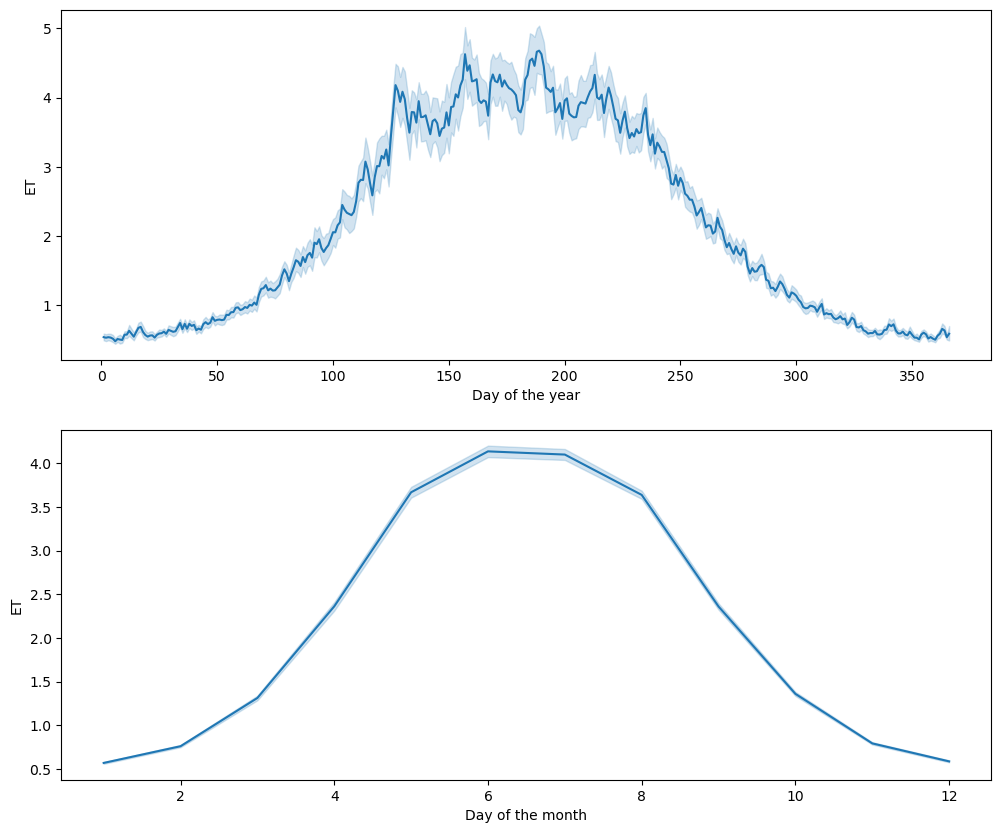

In [7]:
# PET function
# author: Lorenzo Menichetti, on specifications from Martin Bolinder
# Year 2018, August

#PET
#' Internal function to calculate the PET
#'
#' @description  the function is an implementation of the FAO 56 standard for evapotranspiration calculation
#https://www.fao.org/4/X0490E/x0490e00.htm
#' @author Lorenzo Menichetti \email{ilmenichetti@@gmail.com}
#' @param latitude self explanatory
#' @param altitude altitude (meters)
#' @param humidity (percent)
#' @param temperature (C)
#' @param windspeed in m/s
#' @param sun radiation, (MJ  m^-2 day-1) sunlight (0 to 1) or cloudiness (0 to 1)
#' @param sun.mode how sun energy is calculated (Rsolar = radiation energy, sunlight or cloudiness)
#' @param date a date vector
#'
#' @return
#' A data frame of 2 variables: \code{date},\code{PET}.
#'
#'
#' @references
#' Allen, R. G., Pereira, L. S., Raes, D. & Smith, M. Crop Evapotranspiration - Guidelines for Computing Crop Water Requirements - FAO Irrigation and Drainage Paper 56. 15.


def PET(data):
    
    latitude=data.lat 
    altitude=data.alt
    humidity=data.humidity
    temperature=data.air_temp_deg_C 
    windspeed=data.windspeed 
    sun=data.Rsolar
    sun_mode="Rsolar"
    date=data.date
    day=np.array(data.date.dt.dayofyear.tolist())
    
    #convert the date in days of the year 
    #day=pd.Period(date, freq="D")
    #to be sure humidity does not go above 100
    humidity=np.where(humidity>100, 100, humidity)
    
    #calculate penman=Eto from cloud etc;
    vind2m =windspeed*4.87/(np.log(67.8*10-5.42))     #eq47;
    
    #parameters;
    P=101.3*((293-0.0065*altitude)/293)**5.26   #eq7;
    lambda_p=2.45 # renamed lambda because it is a reserved key in python
    cp=0.001013
    epsilon=0.622
    gamma=cp*P/(epsilon*lambda_p) #eq8;
    
    #vapour pressure deficit;
    es=0.6108*np.exp(17.27*temperature/(temperature+237.3)) #eq12;
    ea=humidity/100*es; #eq17;
    vpd=es-ea
    
    
    #calulation of shortwave (or solar) radiation Rs from cloudiness;
    Gsc=0.082
    pi=3.141592654
    dr=1+0.033*np.cos(2*pi/365*day);  #eq23;
    de=0.409*np.sin(2*pi/365*day-1.39);  #eq24;
    radians=pi/180*latitude;  #eq22;

    ws=np.arccos(-np.tan(radians)*np.tan(de));  #eq25;
    Ra= 24*60/pi*Gsc*dr*(ws*np.sin(radians)*np.sin(de)+np.cos(radians)*np.cos(de)*np.sin(ws));    #eq21;
    Radevap=Ra/lambda_p
    Daylight=24/pi*ws;  #eq34;
    #where the function differs depending on the sunlight mode
    #eq35 if solar rad not measured;
    try:
        if sun_mode=="Rsolar":
            Rs=sun
        elif sun_mode=="sunlight":
            Rs= (0.25+0.5*sun)*Ra*1.05
        elif sun_mode=="cloudiness":
             sunlight=1-sun
             Rs=(0.25+0.5*sunlight)*Ra*1.05
    except:raise ValueError #please provide either Rsolar, sunlight (from 0 to 1) or cloudiness (from 0 to 1)","\n")
        
    
    #1.05 correction according to calibration;

  #calulation of net radiation and longwave radiation;
    Rso=(0.75+0.00002*altitude)*Ra  #eq37;
    albedo=0.23
    Rns=(1-albedo)*Rs;   #eq38;
    TmeanK=273.15+temperature
    SBolz=4.903*10**(-9)
    RsRso=np.min(Rs/Rso) # chech with Lorenzo for possible correction
    Rnl=SBolz*TmeanK**4*(0.34-0.14*ea**0.5)*(1.35*RsRso-0.35); #eq39;
    Rn=Rns-Rnl
    
    delta=(4098*(0.6108*np.exp(17.27*temperature/(temperature+237.3)))/((temperature+237.3)**2));  #eq13;

    Etotal=0.408*delta*Rn + gamma*900/(temperature+273)*vind2m*vpd; #eq6 page 65;
    Etonam=delta+gamma*(1+0.34*vind2m); #eq6 page 65;
    Et0= Etotal/ Etonam; #eq6 page 65;
    Et0=np.where(Et0<0, 0, Et0)
    df_ET=pd.DataFrame({"date":date, "month":data.month,"day":day,"ET":Et0})
    
    return df_ET
    
#testing the function
test_data=pd.read_csv("Ekebo_weather.csv")
test_data["date"]=pd.to_datetime(test_data.date)

ET_data=PET(test_data)

fig, axs=plt.subplots(ncols=1,nrows=2, figsize=(12,10))
sns.lineplot(data=ET_data, x="day", y="ET", ax=axs[0])
axs[0].set_xlabel("Day of the year")
sns.lineplot(data=ET_data, x="month", y="ET", ax=axs[1])
axs[1].set_xlabel("Day of the month")
plt.show();

### Water balance model

The water balance model is a relatively simple bucket model that calculates the water in soil at any time step by calculating the balance between the water already there, the precipitations, the evaporation, the water intercepted by the crop and the percolated water.
The formulas come mainly from  Allen et al., 1998 <https://www.fao.org/3/x0490e/x0490e00.htm> .

```mermaid
graph TD    
    A[Start] --> B[Initialize vectors and set soil water to max]
    B --> C[For loop: i in 1:time series lenght]
    C --> D[Calculate crop coefficient Kc from GAI]
    D --> E[Calculate crop ET ETc from ref ET ET0]
    E --> F[Calculate crop intercepted water]
    F --> G[Calculate potential ET Epot]
    G --> H[Calculate percolation]
    H --> I[Calculate theta]
    I --> J[Calculate Kr]
    J --> K[If Kr > 1, set Kr to 1]
    K --> L[Calculate Eact]
    L --> M[Update water balance]
    M --> C
    M --> N[End]

```


The loop is initialized by setting the soil water content $WC$ to the maximum soil water storage capacity $\theta_{fc} \cdot L$, where $L$ is the length of the soil we are modeling.  

1. **Calculate single crop coefficient Kc**  
The crop coefficient, needed for the following calculations, is calculated based on green area index (GAI) for each time spet ($i$):  
   $$k_{c_i} = 1.3 - 0.5 \cdot e^{(-0.17 \cdot GAI_{(i)})}$$
2. **Calculate ETc**  
We then have to calculat4 the crop evapotraspiration in standard condition from the standard evapotraspiration $ET_0$  
   $$ET_c = ET_{0_i} \cdot k_{c_i} $$
3. **Calculate intercepted water**
Then we calculate the water intercepted by the crop:  
$$
\text{int} =
\begin{cases} 
      \text{prec}[i] & \text{if } \text{prec}[i] \leq \text{ETc} \text{ and } \text{prec}[i] \leq 0.2 \times \text{GAI}[i] \\
      \text{ETc} & \text{if } \text{ETc} \leq \text{prec}[i] \text{ and } \text{ETc} \leq 0.2 \times \text{GAI}[i] \\
      0.2 \times \text{GAI}[i] & \text{if } 0.2 \times \text{GAI}[i] \leq \text{prec}[i] \text{ and } 0.2 \times \text{GAI}[i] \leq \text{ETc}
\end{cases}
$$

4. **Calculate Epot**
The potential evapotraspiration from the crop is calculated as crop ET $ET_c$ minus the water intercepted by the crop:  
$$ET_{c_{pot}} = ET_c - \text{int} $$

5. **Calculate bypass**
Next step is calculatig the eventual percolation. This is zero whenever the current water is less than the maximum storage capacity of the soil, otherwise the difference.
$$
\text{bypass}[i] =
\begin{cases} 
      0 & \text{if } \text{water}[i] \leq \text{tfield} \times L \\
      \text{water}[i] - (\text{tfield} \times L) & \text{if } \text{water}[i] > \text{tfield} \times L
\end{cases}
$$

6. **Calculate theta**
We then need the actual soil water content as volumetric coefficient:  
$$\theta = \frac{WC}{L}$$

7. **Calculate soil evaporation reduction coefficient Kr**
This factor represent the reduction of evaporation due to the energy limitations due to the water phase changes. It is 1 whenever the soil surface is wet (in this case this means that $K_r$ cannot be above 1), less otherwise.
$$
K_r =
\begin{cases} 
      1 & \text{if } \left(1 - \frac{0.95 \times \text{tfield} - \theta}{0.95 \times \text{tfield} - \alpha \times \text{twilt}}\right)^2 > 1 \\
      \left(1 - \frac{0.95 \times \text{tfield} - \theta}{0.95 \times \text{tfield} - \alpha \times \text{twilt}}\right)^2 & \text{otherwise}
\end{cases}
$$

8. **Calculate Eact**
We then use $K_r$ to calculate the actual evapotranspiration:
$$ET_{act} = ET_{pot} \cdot K_r$$

9. **Update water**
We now have all the elements to close our water balance model:
$$WC_{i+1} = WC_i + \text{prec} - ET_{act} - \text{int} - \text{perc}$$

* Monteith, J. L. (1977). "Climate and the efficiency of crop production in Britain." Philosophical Transactions of the Royal Society of London. Series B, Biological Sciences, 281(980), 277-294.

* Jones, J. W., et al. (2003). "The DSSAT cropping system model." European Journal of Agronomy, 18(3-4), 235-265.

* Daughtry, C. S. T., et al. (1992). "Estimating Corn Leaf Chlorophyll Concentration from Reflectance Measurements." Remote Sensing of Environment, 39(2), 95-106.


* Meyer, W. S., & Green, G. C. (1981). "Plant Indicators of Crop Water Status." Advances in Agronomy, 33, 73-110.

* Ewert, F. (2004). "Modelling Plant Responses to Elevated CO2: How Important is Leaf Area Index?" Annals of Botany, 93(5), 619-627.

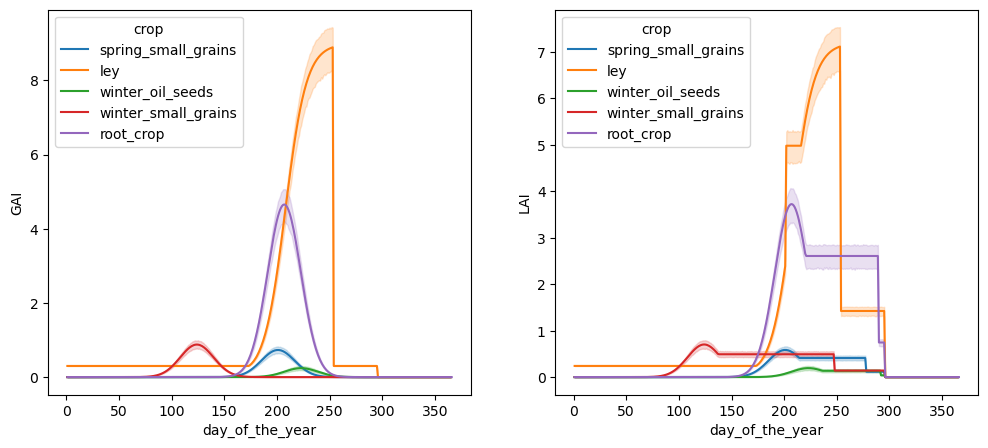

In [44]:
def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def calculate_GAImax(yield_val, crop):
    if crop == "root_crop":
        LAImax_vec = np.array([4.9, 6.5, 5.4])
        yield_vec = np.array([5317, 8080, 8031])
        return min(5.6, (1 / 0.8) * np.mean(LAImax_vec / yield_vec) * (1 / 0.75) * yield_val)
    if crop == "fodder":
        return min(10, 0.0004615385 * yield_val)
    if crop == "fodder_maize":
        return min(10, (1 / 0.8) * 0.000533 * yield_val)
    if crop == "ley":
        return min(10, 0.0018 * yield_val)
    return 0.0129 * (yield_val / 1000) ** 2 + 0.1964 * (yield_val / 1000)

# Example usage
yield_val = 8000  # example yield value in kg/ha
crop = "root_crop"  # example crop type
GAI_max = calculate_GAImax(yield_val, crop)
print(f"GAI_max for {crop} with yield {yield_val} is {GAI_max}")

def GAI_optimized(yield_vals, crops, years, variances, seedings, harvests, tillages, minimum_covers, yield2=None, harvest2=None):
    GAI_list = []
    LAI_list = []
    crop_list = ["spring_small_grains", "spring_oil_seeds", "winter_small_grains", "winter_oil_seeds", "root_crop"]

    for j in range(len(yield_vals)):
        if pd.isna(years[j]):
            raise ValueError(f"Problem with year number {j}, it results {years[j]}")
        
        days_in_year = 366 if is_leap_year(years[j]) else 365
        day_seq = np.arange(1, days_in_year + 1)
        GAImax = calculate_GAImax(yield_vals[j], crops[j])
        GAI = np.zeros(len(day_seq))
        
        if crops[j] in crop_list:
            middle = seedings[j] + (harvests[j] - seedings[j]) / 2
            middle = int(middle)  
            GAI = np.where(day_seq >= seedings[j], GAImax * np.exp(-((day_seq - middle) ** 2) / (2 * variances[j])), 0)
            if crops[j] == "root_crop":
                GAI[day_seq > harvests[j]] = 0
        elif crops[j] in ["fodder", "fodder_maize", "ley"]:
            for i in range(len(day_seq)):
                if day_seq[i] > seedings[j]:
                    GAI[i] = GAImax / (1 + np.exp(-((day_seq[i] - seedings[j]) - (harvests[j] - seedings[j]) / 2) / 10))
                if day_seq[i] > harvests[j]:
                    GAI[i] = 0
            if crops[j] == "ley" and yield2 is not None and harvest2[j] != 0:
                GAImax2 = min(10, 0.0018 * yield2[j])
                for i in range(harvests[j], len(day_seq)):
                    if day_seq[i] < harvest2[j]:
                        GAI[i] = GAImax2 / (1 + np.exp(-((day_seq[i] - harvests[j]) - (harvest2[j] - harvests[j]) / 2) / 10))
                    else:
                        GAI[i] = minimum_covers[j]
        
        if crops[j] not in crop_list:
            GAI = np.maximum(GAI, minimum_covers[j])
        
        if not pd.isna(tillages[j]):
            GAI[int(tillages[j]):] = 0
        
        GAI_dates = [datetime(years[j], 1, 1) + timedelta(days=int(day)-1) for day in day_seq]
        GAI_list.append(pd.DataFrame({'GAI': GAI, 'GAI_date': GAI_dates, 'crop': crops[j], 'yield': yield_vals[j]}))

        LAI = GAI * 0.8
        if crops[j] != "missing":
            LAI[middle:harvests[j]] = np.maximum(LAI[middle:harvests[j]], np.max(LAI) * 0.7)
            LAI[harvests[j]:int(tillages[j])] = np.max(LAI) * 0.2
        
        LAI_list.append(pd.DataFrame({'LAI': LAI, 'GAI_date': GAI_dates, 'crop': crops[j], 'yield': yield_vals[j]}))
    
    GAI_DF = pd.concat(GAI_list + LAI_list, ignore_index=True)
    return GAI_DF

# Example usage:
df=pd.read_csv("Ekebo_field.csv")
#define input variables
yield_val=df.grain_dm_kg_ha
crops=df.crop_id
years=df.year
variances=df.variance
seedings=df.seeding
harvests=df.harvest
tillages=df.tillage
minimum_covers=df.minimum_cover
yield2=None 
harvest2=None

result = GAI_optimized(yield_val, crops, years, variances, seedings, harvests, tillages, minimum_covers, yield2, harvest2)
#create a new variables showing the day of the year
result["day_of_the_year"]=result["GAI_date"].dt.day_of_year.tolist()
# plot the GAI and LAI
fig, axs=plt.subplots(nrows=1, ncols=2, figsize=[12,5])
sns.lineplot(data=result, x="day_of_the_year", y="GAI",hue="crop",ax=axs[0])
sns.lineplot(data=result, x="day_of_the_year", y="LAI", hue="crop" ,ax=axs[1])
plt.show()

In [132]:
# crearte the soil porosity function

def poros (sand, clay, soc):
    '''
    the function uses sand content, clay content and soil organic carbon content as argument
    and return soil porosity in percentage
    
    '''
    if clay is None:
        
        porosity=(0.3843+(soc*0.0448))+(soc*sand*(-0.0204))
    else:
        porosity=(0.4115+(0.0409*soc))-(0.6089*clay*sand)-(0.0031*(soc**2)*clay)+(0.2276*(clay**3))
    return porosity



def WP (sand, clay, soc):
     wp=0.0086+0.4473*clay-0.0157*soc*clay+0.0123*soc*sand
     
     return wp
 


def FC(sand, soc):
    """
    a single numerical value with the soil field capacity
    Args:
        sand (float): sand  in %
        soc (float): soc in %

    Returns:
        float: water content at field capacity
    Tóth, B., M. Weynants, A. Nemes, A. Makó, G. Bilas, and G. Tóth. 2015. “New Generation of Hydraulic Pedotransfer Functions for Europe: New Hydraulic Pedotransfer Functions for Europe.” European Journal of Soil Science 66 (1): 226–38. https://doi.org/10.1111/ejss.12192.
    """
   
    
    F=(0.4384-0.3839)*sand+(0.0796*soc*sand)
    
    return F


def soiltemp(L, GAI, date, temperature, LAI=None):
    """
    This function calculates soil temperature based on input parameters.
    The function is based on Kätterer and Andrén (2008).
    
    Parameters:
    L : integer
        Thickness of topsoil (mm)
    GAI : array-like
        Green Area Index
    date : array-like
        Dates corresponding to temperature readings
    temperature : array-like
        Temperature readings
    LAI : array-like, optional
        Leaf Area Index. If not provided, it is calculated as 0.8 * GAI.
        
    Returns:
    soilT : numpy array Calculated soil temperatures
    """
    
    Zdepth = L / 20.0
    
    if LAI is None:
        LAI = 0.8 * GAI

    Tsurface = np.zeros(len(temperature))
    soilT = np.zeros(len(temperature) + 1)
    
    for i in range(len(temperature)):
        if temperature[i] < 0:
            Tsurface[i] = 0.20 * temperature[i]
        else:
            Tsurface[i] = temperature[i] * (0.95 + 0.05 * np.exp(-0.4 * (LAI[i] - 3)))
        
        soilT[i + 1] = soilT[i] + (Tsurface[i] - soilT[i]) * 0.24 * np.exp(-Zdepth * 0.017) * np.exp(-0.15 * GAI[i])
    
    return soilT[:-1]
#Test the function
soil_temp=soiltemp(LAI=np.linspace(2,5,1000), L=20, temperature=np.linspace(5,25,1000), date=None, GAI=np.linspace(2,8,1000))


# General SOC model initialization approach


# Calibration approaches



## ICBM multi-site recalibration


## Multi-model multi-site recalibration


## Multi-model Bayesian factorial comparison